<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>
Author: Yury Kashnitsky, Data Scientist at Mail.Ru Group

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

## <center>Assignment #6
### <center> Beating benchmarks in "How good is your Medium article?"
    
[Competition](https://www.kaggle.com/c/how-good-is-your-medium-article). The task is to beat "Assignment 6 baseline".

In [20]:
import os
import json
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import Ridge

The following code will help to throw away all HTML tags from an article content.

In [21]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

Supplementary function to read a JSON line without crashing on escape characters.

In [22]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

Extract features `content`, `published`, `title` and `author`, write them to separate files for train and test sets.

In [23]:
def extract_features_and_write(path_to_data,
                               inp_filename, is_train=True):
    
    features = ['content', 'published', 'title', 'author']
    prefix = 'train' if is_train else 'test'
    feature_files = [open(os.path.join(path_to_data,
                                       '{}_{}.txt'.format(prefix, feat)),
                          'w', encoding='utf-8')
                     for feat in features]
    
    with open(os.path.join(path_to_data, inp_filename), 
              encoding='utf-8') as inp_json_file:

        for line in tqdm(inp_json_file):
            json_data = read_json_line(line)
            
        
            
            # You code here

In [6]:
PATH_TO_DATA = '/Users/owner/data/medium' # modify this if you need to

In [10]:

preprocess_title(path_to_input_json_file=os.path.join(PATH_TO_DATA, 'train.json'),
           path_to_out_txt_file= os.path.join(PATH_TO_DATA,'train_titles.txt'))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [11]:
%%time
preprocess_title(path_to_input_json_file=os.path.join(PATH_TO_DATA, 'test.json'),
           path_to_out_txt_file= os.path.join(PATH_TO_DATA,'test_titles.txt'))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


CPU times: user 11 s, sys: 1.04 s, total: 12 s
Wall time: 12.6 s


In [24]:
def preprocess_content(path_to_input_json_file, path_to_out_txt_file):
    with open(path_to_input_json_file, encoding='utf-8') as inp_file, \
    open(path_to_out_txt_file,'w', encoding='utf-8') as out_file:
        for line in tqdm(inp_file):
            json_data = read_json_line(line)
            content = json_data['content'].replace('\n',' ').replace('\r',' ')
            content_no_html_tags = strip_tags(content)
            out_file.write(content_no_html_tags + '\n')
        

In [25]:
%%time
preprocess_content(path_to_input_json_file=os.path.join(PATH_TO_DATA, 'train.json'),
           path_to_out_txt_file=os.path.join(PATH_TO_DATA,'train_content.txt'))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


CPU times: user 4min 41s, sys: 4.46 s, total: 4min 46s
Wall time: 5min 3s


In [26]:
%%time
preprocess_content(path_to_input_json_file=os.path.join(PATH_TO_DATA, 'test.json'),
           path_to_out_txt_file=os.path.join(PATH_TO_DATA,'test_content.txt'))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


CPU times: user 2min 37s, sys: 2.63 s, total: 2min 40s
Wall time: 2min 47s


In [27]:
# Let's implement easy feature extraction - CountVectorizer (Bag of Words representation)
c_vec = CountVectorizer(max_features=50000)


In [28]:
with open(os.path.join(PATH_TO_DATA, 'train_content.txt'), 
              encoding='utf-8') as inp_train_file:
    X_train = c_vec.fit_transform(inp_train_file)

In [29]:
with open(os.path.join(PATH_TO_DATA,'test_content.txt'), encoding='utf-8') as inp_test_data:
    X_test = c_vec.fit_transform(inp_test_data)

In [30]:
X_train.shape, X_test.shape

((62313, 50000), (34645, 50000))

In [31]:
#Reading target from file
train_target= pd.read_csv(os.path.join(PATH_TO_DATA,'train_log1p_recommends.csv'), 
                           index_col='id')

In [32]:
train_target.head()

,log_recommends
id,
8,9.01201
14,3.49651
19,0.69315
22,1.38629
29,1.94591


In [33]:
y_train = train_target['log_recommends'].values

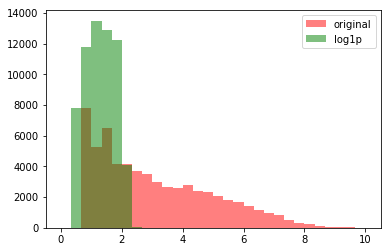

In [34]:
from matplotlib import pyplot as plt
plt.hist(y_train, bins=30, alpha=.5, color='red', label='original', range=(0,10));
plt.hist(np.log1p(y_train), bins=30, alpha=.5, color='green', label='log1p', range=(0,10));
plt.legend();

In [60]:
#Take logs of data again

In [35]:
#Divide into train and test
train_size = int(0.7*train_target.shape[0])
X_train_part = X_train[:train_size,:]
y_train_part = y_train[:train_size]
X_test_part = X_train[train_size:,:]
y_test_part = y_train[train_size:]

In [36]:
ridge = Ridge(random_state=17)


In [37]:
%%time
ridge.fit(X_train_part, np.log1p(y_train_part));


CPU times: user 2min 52s, sys: 2.32 s, total: 2min 54s
Wall time: 3min 11s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [38]:
ridge_fc = np.expm1(ridge.predict(X_test_part))

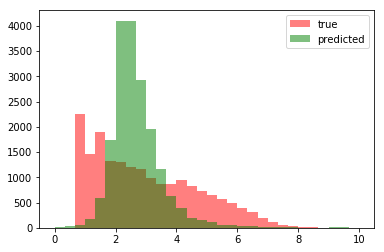

In [39]:
plt.hist(y_test_part, bins = 30, alpha = 0.5, color = 'red', label = 'true', range = (0,10));
plt.hist(ridge_fc, bins = 30, alpha = 0.5, color = 'green', label = 'predicted', range = (0,10));
plt.legend();



In [40]:
# MAE
valid_mae = mean_absolute_error(y_test_part,ridge_fc)
valid_mae, np.expm1(valid_mae)

(48.504780721815514, 1.1624080620468354e+21)

MAE is ~48.5 which corresponds to ~1.16  error in # of recommendations

In [41]:
# Train on the full set
ridge.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [43]:
X_train.shape, X_test.shape

((62313, 50000), (34645, 50000))

In [44]:
ridge_predictions = ridge.predict(X_test)

In [45]:
def write_submission_file(prediction, filename,
                          path_to_sample='../data/sample_submission.csv'):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [50]:
write_submission_file(ridge_predictions, filename=os.path.join(PATH_TO_DATA,'ridge_1.csv'), path_to_sample=os.path.join(PATH_TO_DATA,'sample_submission.csv'))

In [ ]:
# Add feature titles

In [9]:
def preprocess_title(path_to_input_json_file, path_to_out_txt_file):
    with open(path_to_input_json_file, encoding='utf-8') as inp_file, \
    open(path_to_out_txt_file,'w', encoding='utf-8') as out_file:
        for line in tqdm(inp_file):
            json_data = read_json_line(line)
            content = json_data['title'].replace('\n', ' ').replace('\r', ' ')
            content_no_html_tags = strip_tags(content)
            out_file.write(content_no_html_tags + '\n')
        

In [ ]:
# WORK IN PROGRESS

data = []

def extract_features_and_write(path_to_data,
                               inp_filename, is_train=True):
    
    features = ['content', 'published', 'title', 'author']
    prefix = 'train' if is_train else 'test'
    feature_files = [open(os.path.join(path_to_data,
                                       '{}_{}.txt'.format(prefix, feat)),
                          'w', encoding='utf-8')
                     for feat in features]
    
    with open(os.path.join(path_to_data, inp_filename), 
              encoding='utf-8') as inp_json_file:

        for line in tqdm(inp_json_file):
            json_data = read_json_line(line)
            df = {}
            df['published'] = json_data['published']['$time']
            df['author'] = json_data['meta_tags']['article:author']
            df['title'] = json_data['title']
            data.append{df}
        return data
            
            # You code here

In [68]:
import re
#data = []
def if_exists(feature):
    if type(feature) is None:
        return 0
    else:
        return 1

def extract_features_and_write(path_to_data,
                               inp_filename, is_train=True):
    data = []
    features = ['content', 'published', 'title', 'author']
    prefix = 'train' if is_train else 'test'
    feature_files = [open(os.path.join(path_to_data,
                                       '{}_{}.txt'.format(prefix, feat)),
                          'w', encoding='utf-8')
                     for feat in features]
    with open(os.path.join(path_to_data, inp_filename), 
              encoding='utf-8') as inp_json_file:
        
        for line in tqdm(inp_json_file):
            json_data = read_json_line(line)
            df = {}
            #df['id']  = json_data['_id']
            #df['timestamp'] = json_data['_timestamp']
            #df['spider'] = json_data['_spider']
            df['domain'] = json_data['domain']
            df['published'] = json_data['published']['$date']
            df['title'] = json_data['title']
            df['content'] = strip_tags(json_data['content'])
            #df['author_name'] = json_data['author']['name']
            #df['img'] = if_exists(json_data['image_url'])
            #df['tags'] = len(json_data['tags'])
            df['description'] = json_data['meta_tags']['description']
            df['author'] = json_data['meta_tags']['article:author']
            df['robots'] = json_data['meta_tags']['robots'].split(',')[0] #lambda x: 1 if 'noindex' not in json_data['meta_tags']['robots'] else 0
            df['min_to_read'] = re.split('\s', json_data['meta_tags']['twitter:data1'])[0]
            data.append(df)
    return data

In [61]:
extract_features_and_write(PATH_TO_DATA, 'train.json', is_train=True)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

[{'author': 'https://medium.com/@Medium',
  'content': 'MediumEveryone’s stories and ideasAug 13, 2012Medium Terms of\xa0ServiceEffective: March 7, 2016These Terms of Service (“Terms”) are a contract between you and A Medium Corporation. They govern your use of Medium’s sites, services, mobile apps, products, and content (“Services”).By using Medium, you agree to these Terms. If you don’t agree to any of the Terms, you can’t use Medium.We can change these Terms at any time. We keep a historical record of all changes to our Terms on GitHub. If a change is material, we’ll let you know before they take effect. By using Medium on or after that effective date, you agree to the new Terms. If you don’t agree to them, you should delete your account before they take effect, otherwise your use of the site and content will be subject to the new Terms.Content rights & responsibilitiesYou own the rights to the content you create and post on Medium.By posting content to Medium, you give us a nonexcl

In [ ]:
extract_features_and_write(PATH_TO_DATA, 'test.json', is_train=False)

In [163]:
df_tr = pd.DataFrame(data= extract_features_and_write(PATH_TO_DATA, 'train.json', is_train = True))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [164]:
test_df = pd.DataFrame(data= extract_features_and_write(PATH_TO_DATA, 'test.json', is_train=False))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [71]:
df_tr.head(3)

,author,content,description,domain,min_to_read,published,robots,title
0,https://medium.com/@Medium,"MediumEveryone’s stories and ideasAug 13, 2012...",These Terms of Service (“Terms”) are a contrac...,medium.com,5,2012-08-13T22:54:53.510Z,index,Medium Terms of Service – Medium Policy – Medium
1,https://medium.com/@Medium,"MediumEveryone’s stories and ideasAug 2, 2015 ...",This agreement (“Amendment”) is an amendment t...,medium.com,7,2015-08-03T07:44:50.331Z,noindex,Amendment to Medium Terms of Service Applicabl...
2,https://medium.com/@aelcenganda,"Yun-Chen Chien（簡韻真）Nobody in @g0v.tw, PM in se...",閩東海濱是個山接海的地方，沿海是小小的灣澳錯落，漁船或遠或近地停泊。當我們沿著海邊走時，羅士...,medium.com,2,2017-02-05T13:08:17.410Z,index,走入山與海之間：閩東大刀會和兩岸走私 – Yun-Chen Chien（簡韻真） – Medium


In [74]:
df_tr.published= df_tr.published.astype('datetime64[ns]')

In [75]:
df_tr.min_to_read = df_tr.min_to_read.astype(int)

In [123]:
df_tr.fillna(0)

,author,content,description,domain,min_to_read,published,robots,title
0,https://medium.com/@Medium,"MediumEveryone’s stories and ideasAug 13, 2012...",These Terms of Service (“Terms”) are a contrac...,medium.com,5,2012-08-13 22:54:53.510,index,Medium Terms of Service – Medium Policy – Medium
1,https://medium.com/@Medium,"MediumEveryone’s stories and ideasAug 2, 2015 ...",This agreement (“Amendment”) is an amendment t...,medium.com,7,2015-08-03 07:44:50.331,noindex,Amendment to Medium Terms of Service Applicabl...
2,https://medium.com/@aelcenganda,"Yun-Chen Chien（簡韻真）Nobody in @g0v.tw, PM in se...",閩東海濱是個山接海的地方，沿海是小小的灣澳錯落，漁船或遠或近地停泊。當我們沿著海邊走時，羅士...,medium.com,2,2017-02-05 13:08:17.410,index,走入山與海之間：閩東大刀會和兩岸走私 – Yun-Chen Chien（簡韻真） – Medium
3,https://medium.com/@vaibhavkhulbe,Vaibhav KhulbeAndroid App Developer | I write ...,Answer this question yourself. What’s the high...,medium.com,3,2017-05-06 08:16:30.776,index,How fast can a camera get? – What comes to min...
4,https://medium.com/@vaibhavkhulbe,Vaibhav KhulbeAndroid App Developer | I write ...,At this point you must be wary about my brain’...,medium.com,4,2017-06-04 14:46:25.772,index,A game for the lonely fox – What comes to mind...
5,https://medium.com/@pettykate,"Kate Reed Pettyi like you. pettykate.comApr 2,...",I got the idea while reading this Leah Finnega...,medium.com,7,2017-04-02 16:21:15.171,index,Now That’s Comedy – Kate Reed Petty – Medium
6,https://medium.com/@exedre,exedreauthor ● about.me/exedre ● esomma@ieee.o...,Un grande segreto e non sto parlando degli ali...,medium.com,12,2016-08-15 04:16:02.103,index,Che fine ha fatto «Gola Profonda»? – exedre – ...
7,https://medium.com/@RaghavHaran,Raghav HaranHelping ambitious people build car...,Working professionals aged 24–35 who travel fr...,medium.com,5,2015-01-14 21:31:07.568,index,Airbnb Guerilla Usability Testing – Interactiv...
8,https://medium.com/@___fl,Francine LeeUX + Visual: http://francine.ioFeb...,"Dropbox is a great product, but a quick usabil...",medium.com,4,2014-02-11 04:11:54.771,index,A Guerilla Usability Test on Dropbox Photos – ...
9,https://medium.com/@RaghavHaran,Raghav HaranHelping ambitious people build car...,Maybe it’s just because I’m from the Midwest. ...,medium.com,8,2015-10-25 02:58:05.551,index,How to Get Any Job You Want (even if you’re un...


In [127]:
feat_target = train_target.drop('log_recommends', axis = 1)
feat_target = feat_target.reset_index()

In [128]:
feat_target.index.values

array([    0,     1,     2, ..., 62310, 62311, 62312])

In [129]:
feat_flatten = feat_target.index.values.flatten() # sequence of indices

In [130]:
range(0,feat_flatten.shape[0]+10,10)

range(0, 62323, 10)

In [131]:
feat_train_sparse = csr_matrix(([1] * feat_flatten.shape[0],
                                feat_flatten,
                                range(0, feat_flatten.shape[0])))[:, 1:]


In [161]:
from sklearn.preprocessing import StandardScaler
def fit_feature(lmdb, feature, col, axis = 0):
    feat_target[feature] = df_tr[col].apply(lmbd, axis)
    feat_test[feature] = test_df[col].apply(lmbd, axis)
    if axis != 0:
        feat_target[feature].values.reshape(len(df_tr[col]), 1)
    scaler = StandardScaler()
    scaled_feature = feature + '_scaled'
    feat_target[scaled_feature] = scaler.fit_transform(feat_target[feature].values.reshape(-1, 1))
    feat_test[scaled_feature] = scaler.transform(feat_test[feature].values.reshape(-1, 1))

In [162]:
lmbd = lambda ts: ts.date().weekday()
feature = 'weekday'
column = 'published'
fit_feature(lmbd,feature,column)

NameError: name 'test_df' is not defined

In [138]:
lmbd = lambda x: 1 if x.date().weekday() in (5, 6) else 0
feature = 'is_weekend'
column = 'published'
fit_feature(lmbd,feature,column)


/Users/owner/anaconda/envs/fastai/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [141]:
feat_target['time_to_read'] = df_tr['min_to_read']

lmbd = lambda ts: len(ts)
feature = 'text_length'
reason = 'content'
fit_feature(lmbd,feature,reason)

/Users/owner/anaconda/envs/fastai/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [142]:
lmbd = lambda ts: ts.hour
feature = 'hour'
reason = 'published'
fit_feature(lmbd,feature,reason)

lmbd = lambda ts: int(ts.hour > 6 and ts.hour <= 12)
feature = 'morning'
reason = 'published'
fit_feature(lmbd,feature,reason)

lmbd = lambda ts: int(ts.hour > 12 and ts.hour <= 18)
feature = 'afternoon'
reason = 'published'
fit_feature(lmbd,feature,reason)

lmbd = lambda ts: int(ts.hour > 18 and ts.hour <= 23)
feature = 'evening'
reason = 'published'
fit_feature(lmbd,feature,reason)

lmbd = lambda ts: int(ts.hour > 23 and ts.hour <= 6)
feature = 'night'
reason = 'published'
fit_feature(lmbd,feature,reason)

/Users/owner/anaconda/envs/fastai/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


**Add the following groups of features:**
    - Tf-Idf with article content (ngram_range=(1, 2), max_features=100000 but you can try adding more)
    - Tf-Idf with article titles (ngram_range=(1, 2), max_features=100000 but you can try adding more)
    - Time features: publication hour, whether it's morning, day, night, whether it's a weekend
    - Bag of authors (i.e. One-Hot-Encoded author names)

In [143]:
feat_target['morning'] = feat_target['morning'].astype(int)
feat_target['afternoon'] = feat_target['afternoon'].astype(int)
feat_target['evening'] = feat_target['evening'].astype(int)
feat_target['night'] = feat_target['night'].astype(int)
feat_target['weekday'] = feat_target['weekday'].astype(int)
feat_target['hour'] = feat_target['hour'].astype(int)
feat_target['is_weekend'] = feat_target['is_weekend'].astype(int)
feat_target['text_length'] = feat_target['text_length'].astype(int)
feat_target.dtypes

id                      int64
weekday                 int64
weekday_scaled        float64
is_weekend              int64
is_weekend_scaled     float64
time_to_read            int64
text_length             int64
text_length_scaled    float64
hour                    int64
hour_scaled           float64
morning                 int64
morning_scaled        float64
afternoon               int64
afternoon_scaled      float64
evening                 int64
evening_scaled        float64
night                   int64
night_scaled          float64
dtype: object

In [146]:
tmp = csr_matrix(feat_target['morning'])
X_train = csr_matrix(hstack([X_train[:], tmp[:].T]))

In [153]:
tmp

<1x62313 sparse matrix of type '<class 'numpy.int64'>'
	with 12014 stored elements in Compressed Sparse Row format>

In [148]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part = X_train[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid =  X_train[train_part_size:, :]
y_valid = y_train[train_part_size:]

In [149]:
ridge = Ridge(random_state=17)
ridge.fit(X_train_part, y_train_part)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [154]:
ridge_new_pred = ridge.predict(X_valid)

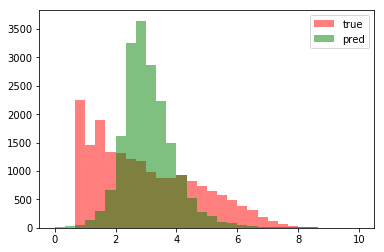

In [156]:
plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(ridge_new_pred, bins=30, alpha=.5, color='green', label='pred', range=(0,10));
plt.legend();

In [159]:
valid_mae = mean_absolute_error(ridge_new_pred, y_valid)
valid_mae, np.expm1(valid_mae)

(1.3061028451133241, 2.6917582870340211)

In [160]:
ridge_new_test_pred = ridge.predict(X_test)

ValueError: dimension mismatch

In [ ]:
# You code here

**Join all sparse matrices.**

In [ ]:
X_train_sparse = csr_matrix(hstack([X_train_content_sparse, X_train_title_sparse,
                                    X_train_author_sparse, X_train_time_features_sparse]))

In [ ]:
X_test_sparse = csr_matrix(hstack([X_test_content_sparse, X_test_title_sparse,
                                    X_test_author_sparse, X_test_time_features_sparse]))

**Read train target and split data for validation.**

In [ ]:
train_target = pd.read_csv('../data/train_log1p_recommends.csv', 
                           index_col='id')
y_train = train_target['log_recommends'].values

In [ ]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part_sparse = X_train_sparse[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid_sparse =  X_train_sparse[train_part_size:, :]
y_valid = y_train[train_part_size:]

**Train a simple Ridge model and check MAE on the validation set.**

**Train the same Ridge with all available data, make predictions for the test set and form a submission file.**

In [ ]:
# You code here

In [ ]:
write_submission_file(ridge_test_pred, 'assignment6_medium_submission.csv')

**Now's the time for dirty Kaggle hacks. Form a submission file with all zeroes. Make a submission. What do you get if you think about it? How is it going to help you with modifying your predictions?**

In [ ]:
write_submission_file(np.zeros_like(ridge_test_pred), 
                      'medium_all_zeros_submission.csv')

**Modify predictions in an appropriate way (based on your all-zero submission) and make a new submission.**

In [ ]:
ridge_test_pred_modif = ridge_test_pred # You code here

In [ ]:
write_submission_file(ridge_test_pred_modif, 
                      'assignment6_medium_submission_with_hack.csv')

In [ ]:
def preprocess(path_to_inp_json_file):
    output_list = []
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file:
        for line in tqdm_notebook(inp_file):
            json_data = read_json_line(line)
            content = json_data['content'].replace('\n', ' ').replace('\r', ' ')
            content_no_html_tags = strip_tags(content)
            output_list.append(content_no_html_tags)
    return output_list


def preprocess(path_to_inp_json_file, path_to_out_txt_file):
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file, open(path_to_out_txt_file, 'w', encoding='utf-8') as out_file:
        for line in tqdm_notebook(inp_file):
            json_data = read_json_line(line)
            content = json_data['title'].replace('\n', ' ').replace('\r', ' ')
            content_no_html_tags = strip_tags(content)
            out_file.write(content_no_html_tags + '\n')